#### This notebook explains how to:
(1) download raw benchmarking data to your local computer 

(2) read raw benchmarking data from S3

(3) read precomputed volume/skeleton benchmarking data via Neuroglancer

#### Quick notes on the benchmarking data:

In octree format, data is labled in folders 1-50. 1-25 correspond with the 1-25 "test" raw data and 26-50 correspond with the 1-25 "validation" raw data

Known issues with a few of the files: 

- test_10 (#10),test_9 (#9) - didnt seem to have good swc alignment

- test_24 (#24) - issues with the image

- validation_11 (#37) - seems to be a shift between swcs and the image


# Downloading Raw Benchmarking Data with AWS CLI

###### This will download the benchmarking data in .tif and .swc format to a local computer

### 1) Installing AWS CLI

You can install AWS CLI for any major operating system:

#### macOS 
(the full documentation uses pip, but Homebrew works more seamlessly):
Documentation: https://docs.aws.amazon.com/cli/latest/userguide/cli-install-macos.html 

```brew install awscli```
#### Linux 
Documentation: https://docs.aws.amazon.com/cli/latest/userguide/awscli-install-linux.html 

```$ pip install awscli```

#### Windows
Documentation: https://docs.aws.amazon.com/cli/latest/userguide/awscli-install-windows.html
Installer: http://docs.aws.amazon.com/cli/latest/userguide/awscli-install-windows.html

### 2) Configuring AWS CLI

Run ```aws configure``` in any command line and follow the prompts.

You will be asked for 
- AWS Access Key ID
- AWS Secrety Access Key
- Default Region Name: us-east-1, us-east-2, us-west-1, us-west-2, ...
- Default output format: json, table, text

### 3.1) Downloading .tif files

Run the command ```aws s3 sync s3://open-neurodata/benchmarking_data/tif-files/ sample-tif-location```

Replace "sample-tif-location" with your respective download destination.

### 3.2) Accessing AND Visualizing .tif files

In [62]:
from pathlib import Path
import numpy as np
from skimage import io

This loops through and reads the .tif files in the download directory. Alter data_dir to point to your download location.

In [26]:
%%capture
data_dir = Path().resolve().parents[5] / "Downloads" / "sample-tif-location"
im_files = list(data_dir.glob("**/*.tif"))

for im_num, im_file in enumerate(im_files):
    print(f"Image {im_num}/{len(im_files)}")
    print(im_file)
    f = im_file.parts[-1][:-8] + "-gfp.tif" 
    im = io.imread(im_file, plugin="tifffile") 

The below code can visualize a specified .tif file. To visualize tif files with .swc overlaid, run the data through the image mask generation notebook.

In [54]:
import napari

file_name = "test_10-gfp.tif" # Can change to any image (test 1-25, validation 1-25)

im_file = data_dir / file_name
im = io.imread(im_file, plugin="tifffile") 
    
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im)

### 4.1) Downloading .swc files

Run the command ```aws s3 sync s3://open-neurodata/benchmarking_data/Manual-GT/ sample-swc-location```

Replace "sample-swc-location" with your respective download destination.

### 4.2) Accessing .swc files

This loops through the .swc files in the download directory. Alter data_dir to point to your file download location.


In [9]:
%%capture
data_dir = Path().resolve().parents[5] / "Downloads" / "sample-swc-location" 
swc_files = list(data_dir.glob("**/*.swc"))

for swc_num, swc_file in enumerate(swc_files):
    print(f"SWC {swc_num}/{len(swc_files)}")
    print(swc_file)
    image_name = swc_file.parts[6]
    swc_num = swc_file.parts[7]

# Read benchmarking data from S3 with boto3
###### This will load the benchmarking .tif images from S3 and can either display them on napari or a local image viewer

### 1) Install and configure boto3

Pip install boto3 if not previously installed.
Save a credentials file in ```~/.aws/credentials.ini```


File format: 

[default]

aws_access_key_id = xxxxxxxxxxxxxxxx

aws_secret_access_key = xxxxxxxxxxxxxxxxxxxxxxxx


### 2) Read the .tif files

In [122]:
import boto3
import os
import numpy as np
from PIL import Image
import io
from io import BytesIO
from pathlib import Path
from skimage import io

f_list = ['test_1-gfp.tif', 'test_2-gfp.tif', 'test_3-gfp.tif', 'test_4-gfp.tif', 'test_5-gfp.tif', 'test_6-gfp.tif',
 'test_7-gfp.tif', 'test_8-gfp.tif', 'test_9-gfp.tif', 'test_10-gfp.tif', 'test_11-gfp.tif', 'test_12-gfp.tif',
 'test_13-gfp.tif', 'test_14-gfp.tif', 'test_15-gfp.tif', 'test_16-gfp.tif', 'test_17-gfp.tif', 'test_18-gfp.tif',
 'test_19-gfp.tif', 'test_20-gfp.tif', 'test_21-gfp.tif', 'test_22-gfp.tif', 'test_23-gfp.tif', 'test_24-gfp.tif',
 'test_25-gfp.tif', 'validation_1-gfp.tif', 'validation_2-gfp.tif', 'validation_3-gfp.tif', 'validation_4-gfp.tif',
 'validation_5-gfp.tif', 'validation_6-gfp.tif', 'validation_7-gfp.tif', 'validation_8-gfp.tif', 'validation_9-gfp.tif',
 'validation_10-gfp.tif', 'validation_11-gfp.tif', 'validation_12-gfp.tif', 'validation_13-gfp.tif', 'validation_14-gfp.tif',
 'validation_15-gfp.tif', 'validation_16-gfp.tif', 'validation_17-gfp.tif', 'validation_18-gfp.tif', 'validation_19-gfp.tif',
 'validation_20-gfp.tif', 'validation_21-gfp.tif', 'validation_22-gfp.tif', 'validation_23-gfp.tif', 'validation_24-gfp.tif',
 'validation_25-gfp.tif']

#HOME = Path("C:/Users/shrey") #Change to specify Home directory if aws config file is not being found.
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('open-neurodata')

#### Read and Visualize a specific .tif file

In [132]:
file = 'test_10-gfp.tif' #Replace with specific .tif file name
print('File name: ', file)

prefix = 'benchmarking_data/tif-files/' + file
objects = my_bucket.objects.filter(Prefix = prefix)
  
for obj in objects:
    path, filename = os.path.split(obj.key)
    im = Image.open(obj.get()['Body'])
    im.show() # Can't visualize on Napari yet (?) but this line will launch image in local image viewer
    

File name:  test_10-gfp.tif


Image to Numpy Array: 
[[11797 11870 11912 ... 12055 12045 11949]
 [12028 12023 12083 ... 12103 11894 11885]
 [12045 12039 12272 ... 12186 11873 11950]
 ...
 [12064 11911 11938 ... 12052 11901 12034]
 [11947 11959 12264 ... 12084 12141 12194]
 [12360 12114 11922 ... 12234 12286 12179]]
File:  test_10-gfp.tif


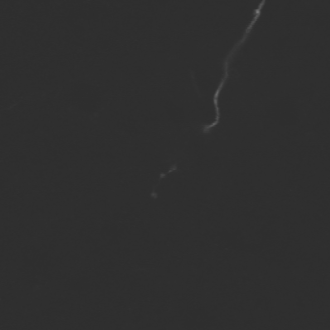

In [133]:
print('Image to Numpy Array: ') #converting to numpy array
print(np.array(im))

print('File: ', file) #viewing image in notebook
im


In [126]:
#Can't vizualize in napari YET, "TypeError: 'TiffImageFile' object is not iterable"
import napari
with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im)
    #viewer.add_labels(labels)

ERROR:root:Unhandled exception:
Traceback (most recent call last):
  File "c:\users\shrey\anaconda3\envs\ndd-windows\lib\site-packages\napari\_qt\event_loop.py", line 79, in gui_qt
    yield app
  File "<ipython-input-126-c09a5a165043>", line 5, in <module>
    viewer.add_image(im)
  File "c:\users\shrey\anaconda3\envs\ndd-windows\lib\site-packages\napari\components\add_layers_mixin.py", line 223, in add_image
    return self.add_layer(layers.Image(data, **kwargs))
  File "c:\users\shrey\anaconda3\envs\ndd-windows\lib\site-packages\napari\layers\image\image.py", line 163, in __init__
    multiscale, data = guess_multiscale(data)
  File "c:\users\shrey\anaconda3\envs\ndd-windows\lib\site-packages\napari\layers\image\_image_utils.py", line 54, in guess_multiscale
    shapes = [d.shape for d in data]
TypeError: 'TiffImageFile' object is not iterable



#### Read ALL 50 .tif files & visualize on local image viewer
Files should pop up in local image viewer (For Windows, it's the Photos app)

In [127]:
%%capture
for file in f_list:
    print('File name: ', file)
    prefix = 'benchmarking_data/tif-files/' + file
    objects = my_bucket.objects.filter(Prefix=prefix)
    
    for obj in objects:
        path, filename = os.path.split(obj.key)
        im = Image.open(obj.get()['Body'])
        im.show()

KeyboardInterrupt: 

# Read benchmarking data from S3 with Neuroglancer
###### This will load the benchmarking data from precomputed volume and skeleton form

In [82]:
from brainlit.utils import session, upload_benchmarking
dest = "s3://open-neurodata/benchmarking_data/1"
dest_segments = "s3://open-neurodata/benchmarking_data/1"

In [83]:
%%capture
sess = session.NeuroglancerSession(url=dest, url_segments=dest_segments, mip=0)  # create session object object
img, bounds, vertices = sess.pull_vertex_list(1, list(range(1,187)), 0, expand=True)  # get image containing some data
#labels = sess.create_tubes(1, [330,300,100], radius=1)  # generate labels via tube segmentation
#print(f"\n\nDownloaded volume is of shape {img.shape}, with total intensity {sum(sum(sum(img)))}.")

OutOfBoundsError: Bbox([0, 0, 0],[330, 330, 100], dtype=int32) did not fully contain the specified bounding box Bbox([0, 0, 300],[330, 330, 400], dtype=int32).